## Исследование наиболее полезных признаков для обучения моделей

In [2]:
import time
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tabulate import tabulate
from tqdm import tqdm
import logging
import warnings
from itertools import combinations

warnings.filterwarnings("ignore")

# Set up logging
logging.basicConfig(filename='training_log.log', level=logging.INFO, format='%(asctime)s - %(message)s')

# 1. Downloading the data
def download_data(tickers, period):
    data = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        df = stock.history(period=period)
        df['Ticker'] = ticker
        data[ticker] = df
    return data

# 2. Plot the data
def plot_data(data):
    n = len(data)
    rows = n // 2 + n % 2
    fig, axes = plt.subplots(rows, 2, figsize=(15, 8))
    axes = axes.flatten()

    for i, (ticker, df) in enumerate(data.items()):
        axes[i].plot(df.index, df['Close'])
        axes[i].set_title(f"{ticker} Closing Prices")

    plt.tight_layout()
    plt.show()

# 3. Create train-test split using sliding windows
def create_train_test_window(df, target_column, window_size=10, prediction_horizon=1, test_size=0.2, scale_range=(-1, 1)):
    scaler = MinMaxScaler(feature_range=scale_range)
    scaled_data = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)
    X, y = [], []
    for i in range(len(scaled_df) - window_size - prediction_horizon + 1):
        X.append(scaled_df.iloc[i:i+window_size].values)
        y.append(scaled_df.iloc[i+window_size:i+window_size+prediction_horizon][target_column].values[0])
    X, y = np.array(X), np.array(y)
    split_idx = int(len(X) * (1 - test_size))
    return X[:split_idx], X[split_idx:], y[:split_idx], y[split_idx:], scaler



# 4. Financial feature engineering
def create_features(df, features_to_generate):
    feature_functions = {
        'Returns': lambda df: df['Close'].pct_change(),
        'Volatility': lambda df: df['Close'].rolling(window=10).std(),
        'Momentum': lambda df: df['Close'] - df['Close'].shift(10),
        'SMA': lambda df: df['Close'].rolling(window=10).mean(),
        'EMA': lambda df: df['Close'].ewm(span=10, adjust=False).mean(),
        'MACD': lambda df: df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean(),
        'RSI': lambda df: 100 - (100 / (1 + (df['Close'].diff().clip(lower=0).rolling(window=14).mean() / df['Close'].diff().clip(upper=0).abs().rolling(window=14).mean()))),
        'StochasticK': lambda df: ((df['Close'] - df['Low'].rolling(window=14).min()) / (df['High'].rolling(window=14).max() - df['Low'].rolling(window=14).min())) * 100,
        'StochasticD': lambda df: (((df['Close'] - df['Low'].rolling(window=14).min()) / (df['High'].rolling(window=14).max() - df['Low'].rolling(window=14).min())) * 100).rolling(window=3).mean(),
        'BollingerBandsUpper': lambda df: df['Close'].rolling(window=20).mean() + (df['Close'].rolling(window=20).std() * 2),
        'BollingerBandsLower': lambda df: df['Close'].rolling(window=20).mean() - (df['Close'].rolling(window=20).std() * 2),
        'ATR': lambda df: (df['High'] - df['Low']).rolling(window=14).mean(),
        'HighLowSpread': lambda df: df['High'] - df['Low'],
        'DailyRange': lambda df: df['High'] - df['Close'].shift(1),
        'VWAP': lambda df: (df['Volume'] * (df['High'] + df['Low'] + df['Close']) / 3).cumsum() / df['Volume'].cumsum(),
        'CCI': lambda df: (df['Close'] - df['Close'].rolling(window=20).mean()) / (0.015 * df['Close'].rolling(window=20).std()),
        'WilliamsR': lambda df: ((df['High'].rolling(window=14).max() - df['Close']) / (df['High'].rolling(window=14).max() - df['Low'].rolling(window=14).min())) * -100,
        'ChaikinMoneyFlow': lambda df: ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low']) * df['Volume'],
        'PriceVolumeTrend': lambda df: (df['Close'].pct_change() * df['Volume']).cumsum()
    }

    for feature_name in features_to_generate:
        if feature_name in feature_functions:
            df[feature_name] = feature_functions[feature_name](df)

    df.dropna(inplace=True)
    return df

# 5. Train and evaluate models
def train_models(X_train, X_test, y_train, y_test, feature_combination, window_size, prediction_horizon, ticker, scaler=None):
    models = {
        'RandomForest': RandomForestRegressor(),
        'GradientBoosting': GradientBoostingRegressor(),
        'LinearRegression': LinearRegression(),
        # 'HistoricalMean': None
    }
    param_grids = {
        'RandomForest': {'n_estimators': [100], 'max_depth': [5]},
        'GradientBoosting': {'n_estimators': [100], 'learning_rate': [0.1]},
        'LinearRegression': {}
    }
    results = []

    for model_name, model in models.items():
        if model_name == 'HistoricalMean':
            # Логирование в виде таблицы
            log_table = [["Action", "Training HistoricalMean model"]]
            logging.info(f"\n{tabulate(log_table, headers='firstrow', tablefmt='grid')}")
            
            y_pred = np.full_like(y_test, np.mean(y_train), dtype=np.float64)
        else:
            # Логирование в виде таблицы
            log_table = [
                ["Action", f"Starting training for {model_name}"],
                ["Parameters", str(param_grids.get(model_name, {}))]
            ]
            logging.info(f"\n{tabulate(log_table, headers='firstrow', tablefmt='grid')}")
            
            grid = GridSearchCV(model, param_grids.get(model_name, {}), cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
            grid.fit(X_train.reshape(X_train.shape[0], -1), y_train)
            best_model = grid.best_estimator_
            
            # Логирование лучших параметров в виде таблицы
            log_table = [
                ["Model", model_name],
                ["Best Parameters", str(grid.best_params_)]
            ]
            logging.info(f"\n{tabulate(log_table, headers='firstrow', tablefmt='grid')}")
            
            y_pred = best_model.predict(X_test.reshape(X_test.shape[0], -1))

        # Вычисление метрик
        metrics = {
            'Ticker': ticker,
            'Model': model_name,
            'MAE': np.round(mean_absolute_error(y_test, y_pred), 3),
            'MSE': np.round(mean_squared_error(y_test, y_pred), 3),
            'RMSE': np.round(np.sqrt(mean_squared_error(y_test, y_pred)), 3),
            'MAPE': np.round(np.mean(np.abs((y_test - y_pred) / y_test)) * 100, 3),
            'R2': np.round(r2_score(y_test, y_pred), 3),
            'Features': ', '.join(feature_combination),
            'Window Size': window_size,
            'Prediction Horizon': prediction_horizon
        }
        
        # Логирование метрик в виде таблицы
        log_table = [[key, value] for key, value in metrics.items()]
        logging.info(f"Metrics for {model_name}:\n{tabulate(log_table, headers=['Metric', 'Value'], tablefmt='grid')}")
        
        results.append(metrics)

    # Логирование завершения обучения
    logging.info("\nTraining complete for all models.")
    
    return results

### Какие признаки дают подолнительный вклад в качество моделей МО?

In [ ]:
# Основная функция для запуска с одним признаком.
if __name__ == "__main__":
    tickers = ['AAPL']
    data = download_data(tickers, period="5y")

    # Построение графиков
    plot_data(data)

    # Определение всех возможных признаков
    all_features = ['Returns', 'Volatility', 'Momentum', 'SMA', 'EMA', 'MACD', 'RSI', 'StochasticK', 'StochasticD', 'BollingerBandsUpper', 'BollingerBandsLower', 'ATR', 'HighLowSpread', 'DailyRange', 'VWAP', 'CCI', 'WilliamsR', 'ChaikinMoneyFlow', 'PriceVolumeTrend']

    # Параметры для перебора
    window_sizes = [14, 28]  # Размеры окон
    prediction_horizons = [1, 3, 7]  # Горизонты предсказания

    # Сохранение всех результатов
    all_results = []

    # Вычисление общего количества запусков
    total_runs = len(tickers) * len(window_sizes) * len(prediction_horizons) * len(all_features)

    # Подготовка данных и обучение моделей
    with tqdm(total=total_runs, desc="Total Progress") as pbar:
        for ticker, df in data.items():
            df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
            
            for window_size in window_sizes:
                for prediction_horizon in prediction_horizons:
                    for feature in all_features:
                        # Создание признаков (только один признак)
                        df_with_features = create_features(df.copy(), features_to_generate=[feature])
                        
                        # Создание обучающих и тестовых данных
                        X_train, X_test, y_train, y_test, scaler = create_train_test_window(df_with_features, target_column='Close', window_size=window_size, prediction_horizon=prediction_horizon)
                        
                        # Логирование начала обучения для тикера
                        log_table = [
                            ["Ticker", ticker],
                            ["Window Size", window_size],
                            ["Prediction Horizon", prediction_horizon],
                            ["Features", feature],
                            ["Action", "Starting training models"]
                        ]
                        logging.info(f"\n{tabulate(log_table, headers='firstrow', tablefmt='grid')}")
                        
                        # Обучение моделей
                        results = train_models(X_train[:, :, [0, -1]], X_test[:, :, [0, -1]], y_train, y_test, [feature], window_size, prediction_horizon)
                        all_results.extend(results)
                        
                        # Обновление прогресс-бара
                        pbar.update(1)

    # Логирование завершения всех задач
    logging.info("\nAll models trained successfully.")

    # Сохранение всех результатов в DataFrame
    results_df = pd.DataFrame(all_results)

    # Поиск наилучшей комбинации для каждой модели
    best_results = results_df.loc[results_df.groupby(['Model', 'Features'])['R2'].idxmax()]

    # Вывод наилучших результатов
    print("\nBest results for each model and feature:")
    print(tabulate(best_results, headers="keys", tablefmt="pretty"))

    # Сохранение результатов в файл
    timestamp = int(time.time())
    results_df.to_csv(f'single_feature_results_{timestamp}.csv', index=False)
    best_results.to_csv(f'best_single_feature_results_{timestamp}.csv', index=False)

In [54]:
for Model, group in best_results.groupby('Model'):
    print(f"\nResults for {Model}:")
    print(tabulate(group.sort_values(by='R2', ascending=False), headers="keys", tablefmt="pretty"))


Results for GradientBoosting:
+-----+------------------+--------+---------+--------+--------+--------+---------------------+-------------+--------------------+
|     |      Model       |  MAE   |   MSE   |  RMSE  |  MAPE  |   R2   |      Features       | Window Size | Prediction Horizon |
+-----+------------------+--------+---------+--------+--------+--------+---------------------+-------------+--------------------+
| 189 | GradientBoosting | 19.963 | 694.735 | 26.358 | 8.799  | -0.058 | BollingerBandsUpper |     14      |         7          |
| 217 | GradientBoosting | 21.043 | 775.106 | 27.841 | 9.263  | -0.182 |      WilliamsR      |     14      |         7          |
| 181 | GradientBoosting | 21.045 | 775.059 | 27.84  | 9.263  | -0.182 |     StochasticK     |     14      |         7          |
| 289 | GradientBoosting | 21.865 | 803.219 | 28.341 | 9.586  | -0.184 |         CCI         |     28      |         1          |
| 185 | GradientBoosting | 21.397 | 794.003 | 28.178 | 9.42

Вывод:
- GradientBoosting:
    - BollingerBandsUpper дала наибольший вклад в прирост качества модели;
    - WilliamsR и StochasticK и дали прирост меньше, однако все три признака смогли предсказать на 7 дней при информации на 14.
- HistoricalMean:
    - очевидно плохая модель, но использована из-за простоты и скорости. Больше использована не будет.
- LinearRegression:
    - очень хорошо себя проявила, однако это не удивительно, ведь акции (тем более голубых фишек) обычно растут, поэтому нужно подобрать акции наиболее волательные или сезонные, возможно, ФосАгро, Абрау-Дюрсо или венчурные, например, Virgin Galactic;
    - при этом прогнозы на 1 день оказались самыми точными, что тоже вполне объяснимо простотой модели.
- RandomForest:
    - Почти все результаты оказались лучше на длинной дистанции (7 дней) при данных за 14 дней.

Мини-итог:
- LinearRegression для прогноза на один день;
- GradientBoosting для более длинных прогнозов, хотя признаки играют роль;
- RandomForest длинные прогнозы лучше коротких всегда;
- HistoricalMean не стоит использовать.

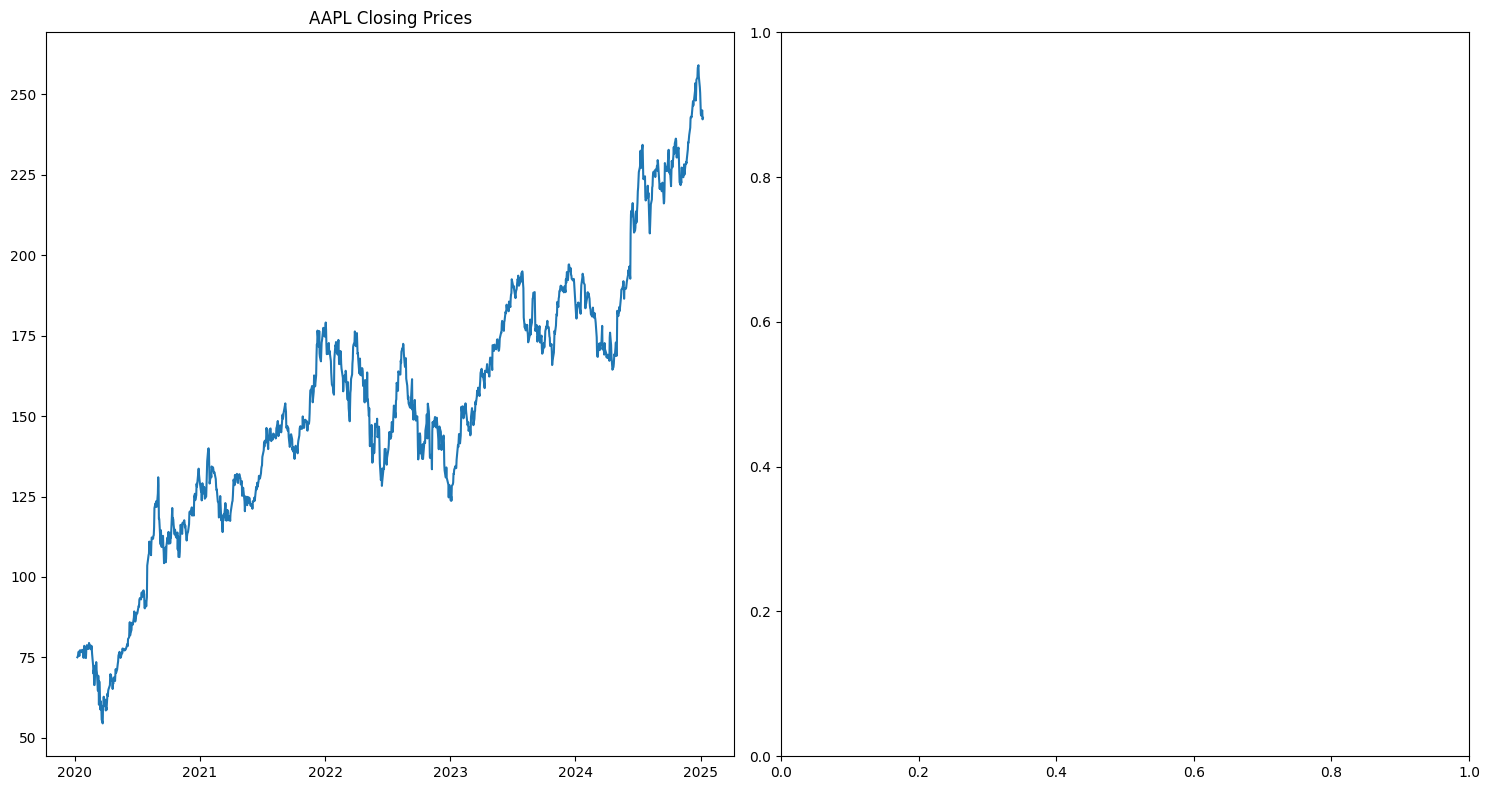

Total Progress: 100%|██████████| 6/6 [00:40<00:00,  6.77s/it]


Best results for each model and feature:
+----+------------------+--------+----------+--------+--------+--------+----------+-------------+--------------------+
|    |      Model       |  MAE   |   MSE    |  RMSE  |  MAPE  |   R2   | Features | Window Size | Prediction Horizon |
+----+------------------+--------+----------+--------+--------+--------+----------+-------------+--------------------+
| 5  | GradientBoosting | 23.339 | 947.458  | 30.781 | 10.241 | -0.417 |  Close   |     14      |         3          |
| 23 |  HistoricalMean  | 66.091 | 5023.746 | 70.878 | 30.821 | -6.662 |  Close   |     28      |         7          |
| 2  | LinearRegression | 2.978  |  15.307  | 3.912  | 1.431  | 0.977  |  Close   |     14      |         1          |
| 8  |   RandomForest   | 21.18  | 788.204  | 28.075 | 9.337  | -0.204 |  Close   |     14      |         7          |
+----+------------------+--------+----------+--------+--------+--------+----------+-------------+--------------------+


In [ ]:
# Основная функция для запуска с одним признаком.
if __name__ == "__main__":
    tickers = ['AAPL']
    data = download_data(tickers, period="5y")

    # Построение графиков
    plot_data(data)

    # Параметры для перебора
    window_sizes = [14, 28]  # Размеры окон
    prediction_horizons = [1, 3, 7]  # Горизонты предсказания

    # Сохранение всех результатов
    all_results = []

    # Вычисление общего количества запусков
    total_runs = len(tickers) * len(window_sizes) * len(prediction_horizons)
    # Подготовка данных и обучение моделей
    with tqdm(total=total_runs, desc="Total Progress") as pbar:
        for ticker, df in data.items():
            df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
            
            for window_size in window_sizes:
                for prediction_horizon in prediction_horizons:
                    # Создание обучающих и тестовых данных
                    X_train, X_test, y_train, y_test, scaler = create_train_test_window(df, target_column='Close', window_size=window_size, prediction_horizon=prediction_horizon, ticker=ticker)
                    
                    # Логирование начала обучения для тикера
                    log_table = [
                        ["Ticker", ticker],
                        ["Window Size", window_size],
                        ["Prediction Horizon", prediction_horizon],
                        ["Features", 'Close'],
                        ["Action", "Starting training models"]
                    ]
                    logging.info(f"\n{tabulate(log_table, headers='firstrow', tablefmt='grid')}")
                    
                    # Обучение моделей
                    results = train_models(X_train[:, :, [0,]], X_test[:, :, [0,]], y_train, y_test, ['Close'], window_size, prediction_horizon)
                    all_results.extend(results)
                    
                    # Обновление прогресс-бара
                    pbar.update(1)

    # Логирование завершения всех задач
    logging.info("\nAll models trained successfully.")

    # Сохранение всех результатов в DataFrame
    results_df = pd.DataFrame(all_results)

    # Поиск наилучшей комбинации для каждой модели
    best_results = results_df.loc[results_df.groupby(['Model', 'Features'])['R2'].idxmax()]

    # Вывод наилучших результатов
    print("\nBest results for each model and feature:")
    print(tabulate(best_results, headers="keys", tablefmt="pretty"))

    # Сохранение результатов в файл
    timestamp = int(time.time())
    results_df.to_csv(f'single_feature_results_{timestamp}.csv', index=False)
    best_results.to_csv(f'best_single_feature_results_{timestamp}.csv', index=False)

Вывод по сравнению с использованием дополнительных признаков:
- GradientBoosting без дополнительных признаков показал результаты хуже и длину предсказания при этом ниже. Признаки для GradientBoosting оказались полезны;
- HistoricalMean очевидно такой же результат, так как не использует признаки в целом;
- LinearRegression также стала точнее с дополнительными признаками;
- RandomForest большого прироста от признаков не получил, однако повышение качества все-таки есть.

Выделим несколько наиболее полезных признаков, которые дали результат лучше базового, оказались полезны хотя бы для двух моделей и будем работать с ними. Также добавим другие акции для сравнения. К таким признакам относятся:
1. BollingerBandsUpper
2. WilliamsR
3. StochasticK
4. CCI
5. StochasticD
6. HighLowSpread
7. Returns

В качестве окон используем 14 и 28 дней, а горизонт 1 и 7 дней для уменьшения количества расчетов.
В качеcтве котировок будут использованы Apple, Virgin Galactic, USD/EUR и Bitcoin.

## Апробация признаков на разных категориях фондового рынка

In [ ]:
# Основная функция для запуска с одним признаком.
if __name__ == "__main__":
    tickers = ['AAPL', 'SPCE', 'EUR=X', 'GBTC']
    data = download_data(tickers, period="5y")

    # Построение графиков
    plot_data(data)

    # Определение всех возможных признаков
    all_features = ['Returns', 'StochasticK', 'StochasticD', 'BollingerBandsUpper', 'HighLowSpread', 'CCI', 'WilliamsR',]

    # Параметры для перебора
    window_sizes = [14, 28]  # Размеры окон
    prediction_horizons = [1, 7]  # Горизонты предсказания

    # Сохранение всех результатов
    all_results = []

    # Вычисление общего количества запусков
    total_runs = len(tickers) * len(window_sizes) * len(prediction_horizons) * len(all_features)

    # Подготовка данных и обучение моделей
    with tqdm(total=total_runs, desc="Total Progress") as pbar:
        for ticker, df in data.items():
            df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
            
            for window_size in window_sizes:
                for prediction_horizon in prediction_horizons:
                    for feature in all_features:
                        # Создание признаков (только один признак)
                        df_with_features = create_features(df.copy(), features_to_generate=[feature])
                        
                        # Создание обучающих и тестовых данных
                        X_train, X_test, y_train, y_test, scaler = create_train_test_window(df_with_features, target_column='Close', window_size=window_size, prediction_horizon=prediction_horizon, )
                        
                        # Логирование начала обучения для тикера
                        log_table = [
                            ["Ticker", ticker],
                            ["Window Size", window_size],
                            ["Prediction Horizon", prediction_horizon],
                            ["Features", feature],
                            ["Action", "Starting training models"]
                        ]
                        logging.info(f"\n{tabulate(log_table, headers='firstrow', tablefmt='grid')}")
                        
                        # Обучение моделей
                        results = train_models(X_train[:, :, [0, -1]], X_test[:, :, [0, -1]], y_train, y_test, [feature], window_size, prediction_horizon, ticker=ticker)
                        all_results.extend(results)
                        
                        # Обновление прогресс-бара
                        pbar.update(1)

    # Логирование завершения всех задач
    logging.info("\nAll models trained successfully.")

    # Сохранение всех результатов в DataFrame
    results_df = pd.DataFrame(all_results)

    # Поиск наилучшей комбинации для каждой модели
    best_results = results_df.loc[results_df.groupby(['Ticker', 'Model', 'Features'])['R2'].idxmax()]

    # Вывод наилучших результатов
    print("\nBest results for each model and feature:")
    print(tabulate(best_results, headers="keys", tablefmt="pretty"))

    # Сохранение результатов в файл
    timestamp = int(time.time())
    results_df.to_csv(f'single_feature_results_{timestamp}.csv', index=False)
    best_results.to_csv(f'best_single_feature_results_{timestamp}.csv', index=False)

In [74]:
for Model, group in best_results.groupby(['Model', 'Ticker']):
    print(f"\nResults for {Model}:")
    print(tabulate(group.sort_values(by='R2', ascending=False), headers="keys", tablefmt="pretty"))


Results for ('GradientBoosting', 'AAPL'):
+----+--------+------------------+--------+---------+--------+-------+--------+---------------------+-------------+--------------------+
|    | Ticker |      Model       |  MAE   |   MSE   |  RMSE  | MAPE  |   R2   |      Features       | Window Size | Prediction Horizon |
+----+--------+------------------+--------+---------+--------+-------+--------+---------------------+-------------+--------------------+
| 10 |  AAPL  | GradientBoosting | 20.558 | 718.629 | 26.807 | 9.017 | -0.064 | BollingerBandsUpper |     14      |         1          |
| 40 |  AAPL  | GradientBoosting | 20.772 | 754.045 | 27.46  | 9.146 | -0.15  |      WilliamsR      |     14      |         7          |
| 25 |  AAPL  | GradientBoosting | 20.979 | 768.663 | 27.725 | 9.237 | -0.172 |     StochasticK     |     14      |         7          |
| 37 |  AAPL  | GradientBoosting | 21.255 | 784.241 | 28.004 | 9.361 | -0.195 |         CCI         |     14      |         7          

Вывод по разным моделям:
- GradientBoosting
    - AAPL: ошибается все также, ничего нового;
    - USD/EUR: высокое качество предсказаний, однако результаты лучше только на 1 день;
    - Bitcoin: удивительно, но результаты для криптовалюты лучше, чем у акции Apple;
    - Virgin Galactic: информация о разнице в торговле оказалась полезнее всего, но все равно качество для венчурного инвестировния низкое;
- LinearRegression
    - AAPL, USD/EUR, Bitcoin: как всегда, лучшая модель для предскзания на один день;
    - Virgin Galactic: модель показала уверенные результаты не только на один день, но даже на неделю;
- RandomForest
    - AAPL, GBTC, SPCE: видимо, повышенная волатильность сложна для модели;
    - USD/EUR: наоборот, модель смогла получить хорошие метрики на 1 день предсказания.


Вывод по разным тикерам (ниже расчитана годовая волатильность):
- AAPL, Bitcoin, Virgin Galactic: возможно, моделям сложно предсказывать эти активы, так как они имеют высокую волатильность;
- USD/EUR: пара валют, в свою очередь, имеют волатильность на порядок ниже, что, видимо, важно для GradientBoosting и RandomForest.

Вывод по признакам:
- какие-то признаки отдельно не выделяются, они так же часто самые полезные, как и дающие наименьший вклад.

In [40]:
def calculate_annualized_volatility(close_prices):
    daily_returns = np.log(close_prices / close_prices.shift(1)).dropna()  # Логарифмические доходности
    daily_volatility = daily_returns.std()  # Стандартное отклонение доходностей
    annualized_volatility = daily_volatility * np.sqrt(252)  # Годовая волатильность
    return annualized_volatility

# Сравнение годовой волатильности
volatility_summary_annualized = {ticker: calculate_annualized_volatility(data[ticker]['Close']) for ticker in tickers}

print("Годовая волатильность для каждого тикера:")
print(tabulate([(ticker, np.round(vol, 3)) for ticker, vol in volatility_summary_annualized.items()], 
               headers=["Тикер", "Годовая волатильность"], tablefmt="pretty"))

Годовая волатильность для каждого тикера:
+-------+-----------------------+
| Тикер | Годовая волатильность |
+-------+-----------------------+
| AAPL  |         0.317         |
| SPCE  |         0.979         |
| EUR=X |         0.074         |
| GBTC  |         0.757         |
+-------+-----------------------+


## Предсказание на различные горизонты времени с фиксированными признаками

Пусть фиксированным признаком будет простейший "Returns", то есть доходность. Также, для начала исследуем прогнозирование на интервалы от 1 дня для 3 месяцев.

In [ ]:
# Основная функция для запуска с одним признаком.
if __name__ == "__main__":
    tickers = ['AAPL', 'SPCE', 'EUR=X', 'GBTC']
    data = download_data(tickers, period="5y")

    # Построение графиков
    plot_data(data)

    # Определение всех возможных признаков
    all_features = ['Returns',]

    # Параметры для перебора
    window_sizes = [14, 28, 56, 112, 224]  # Размеры окон
    prediction_horizons = [1, 7, 14, 28, 84]  # Горизонты предсказания

    # Сохранение всех результатов
    all_results = []

    # Вычисление общего количества запусков
    total_runs = len(tickers) * len(window_sizes) * len(prediction_horizons) * len(all_features)

    # Подготовка данных и обучение моделей
    with tqdm(total=total_runs, desc="Total Progress") as pbar:
        for ticker, df in data.items():
            df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
            
            for window_size in window_sizes:
                for prediction_horizon in prediction_horizons:
                    for feature in all_features:
                        # Создание признаков (только один признак)
                        df_with_features = create_features(df.copy(), features_to_generate=[feature])
                        
                        # Создание обучающих и тестовых данных
                        X_train, X_test, y_train, y_test, scaler = create_train_test_window(df_with_features, target_column='Close', window_size=window_size, prediction_horizon=prediction_horizon, )
                        
                        # Логирование начала обучения для тикера
                        log_table = [
                            ["Ticker", ticker],
                            ["Window Size", window_size],
                            ["Prediction Horizon", prediction_horizon],
                            ["Features", feature],
                            ["Action", "Starting training models"]
                        ]
                        logging.info(f"\n{tabulate(log_table, headers='firstrow', tablefmt='grid')}")
                        
                        # Обучение моделей
                        results = train_models(X_train[:, :, [0, -1]], X_test[:, :, [0, -1]], y_train, y_test, [feature], window_size, prediction_horizon, ticker=ticker)
                        all_results.extend(results)
                        
                        # Обновление прогресс-бара
                        pbar.update(1)

    # Логирование завершения всех задач
    logging.info("\nAll models trained successfully.")

    # Сохранение всех результатов в DataFrame
    results_df = pd.DataFrame(all_results)

    # Поиск наилучшей комбинации для каждой модели
    best_results = results_df.loc[results_df.groupby(['Ticker', 'Model', 'Window Size', 'Prediction Horizon'])['R2'].idxmax()]

    # Вывод наилучших результатов
    print("\nBest results for each model and feature:")
    print(tabulate(best_results, headers="keys", tablefmt="pretty"))

    # Сохранение результатов в файл
    timestamp = int(time.time())
    results_df.to_csv(f'single_feature_results_{timestamp}.csv', index=False)
    best_results.to_csv(f'best_single_feature_results_{timestamp}.csv', index=False)

In [70]:
for Model, group in best_results.groupby([ 'Ticker',]):
    print(f"\nResults for {Model}:")
    print(tabulate(group.sort_values(by='R2', ascending=False), headers="keys", tablefmt="pretty"))


Results for ('AAPL',):
+----+--------+------------------+-------+-------+-------+--------+--------+----------+-------------+--------------------+
|    | Ticker |      Model       |  MAE  |  MSE  | RMSE  |  MAPE  |   R2   | Features | Window Size | Prediction Horizon |
+----+--------+------------------+-------+-------+-------+--------+--------+----------+-------------+--------------------+
| 32 |  AAPL  | LinearRegression | 0.026 | 0.001 | 0.033 | 7.135  | 0.983  | Returns  |     56      |         1          |
| 35 |  AAPL  | LinearRegression | 0.026 | 0.001 | 0.033 | 7.216  | 0.983  | Returns  |     56      |         7          |
| 20 |  AAPL  | LinearRegression | 0.026 | 0.001 | 0.034 | 6.995  | 0.982  | Returns  |     28      |         7          |
| 17 |  AAPL  | LinearRegression | 0.026 | 0.001 | 0.034 | 6.987  | 0.982  | Returns  |     28      |         1          |
| 5  |  AAPL  | LinearRegression | 0.026 | 0.001 | 0.034 | 7.164  | 0.982  | Returns  |     14      |         7    

Вывод по разным моделям:
- GradientBoosting
    - волатильные акции предсказаны гораздно лучше на дальний горизонт;
    - USD/EUR также осталась легкопредсказуемой, но для модели предсказание на 1 день лучше;
- LinearRegression
    - AAPL, USD/EUR: модель лучше предсказала короткий горизонт 1 или 7 дней;
    - Bitcoin, Virgin Galactic: в данном случае, средний и дальний горизонты оказались точнее;
- RandomForest
    - волатильные акции также предсказаны гораздно лучше на дальний горизонт;
    - USD/EUR: наоборот, модель смогла получить хорошие метрики на 1 день предсказания.


Вывод по разным тикерам (ниже расчитана годовая волатильность):
- AAPL, Bitcoin, Virgin Galactic: в основном, проблема не поменялась, волатильные тикеры очевидно сложны для изучения, но, вероятно, появление долгосрочного тренда., то есть увеличение окна для обучения помогает решаить это;
- USD/EUR: пара валют все также лучше предсказывается на короткий горизонт, какое бы окно не было дано.

## Проверка предположений о важности окна для волатильных тикеров
Возьмем набор голубых фишек из индекса S&P 500, выберем наиболее и наименее волотильные и проверим, как меняется точность предсказания в зависимости от размера окна.

In [72]:
tickers = [
    'AAPL',   # Apple Inc.
    'MSFT',   # Microsoft Corporation
    'AMZN',   # Amazon.com Inc.
    'GOOGL',  # Alphabet Inc. (Class A)
    'GOOG',   # Alphabet Inc. (Class C)
    'TSLA',   # Tesla Inc.
    'BRK-B',  # Berkshire Hathaway Inc. (Class B)
    'NVDA',   # NVIDIA Corporation
    'META',   # Meta Platforms Inc. (formerly Facebook)
    'JNJ',    # Johnson & Johnson
    'V',      # Visa Inc.
    'WMT',    # Walmart Inc.
    'PG',     # Procter & Gamble Company
    'MA',     # Mastercard Incorporated
    'UNH',    # UnitedHealth Group Incorporated
    'HD',     # Home Depot Inc.
    'DIS',    # The Walt Disney Company
    'BAC',    # Bank of America Corporation
    'PYPL',   # PayPal Holdings Inc.
    'XOM'     # Exxon Mobil Corporation
]
data = download_data(tickers, period="5y")

# Сравнение годовой волатильности
volatility_summary_annualized = {ticker: calculate_annualized_volatility(data[ticker]['Close']) for ticker in tickers}

# Сортировка по волатильности (от высокой к низкой)
sorted_volatility = sorted(volatility_summary_annualized.items(), key=lambda x: x[1], reverse=True)

# Вывод отсортированных результатов
print("Годовая волатильность для каждого тикера (отсортировано по убыванию):")
print(tabulate([(ticker, np.round(vol, 3)) for ticker, vol in sorted_volatility], 
               headers=["Тикер", "Годовая волатильность"], tablefmt="pretty"))

Годовая волатильность для каждого тикера (отсортировано по убыванию):
+-------+-----------------------+
| Тикер | Годовая волатильность |
+-------+-----------------------+
| TSLA  |         0.671         |
| NVDA  |         0.537         |
| META  |         0.455         |
| PYPL  |         0.453         |
| AMZN  |         0.36          |
|  BAC  |         0.356         |
|  XOM  |         0.344         |
|  DIS  |         0.339         |
| GOOGL |         0.325         |
| GOOG  |         0.324         |
| AAPL  |         0.317         |
|  MA   |         0.309         |
| MSFT  |         0.305         |
|  UNH  |          0.3          |
|  HD   |         0.292         |
|   V   |         0.278         |
|  WMT  |         0.226         |
| BRK-B |         0.217         |
|  PG   |         0.21          |
|  JNJ  |         0.197         |
+-------+-----------------------+


Зная, что моделям нужно большее окно и предсказания на дальний горизонт точнее, оставим соответствующие параметры, однако, оставим возможность прогнозирования на 1 день.

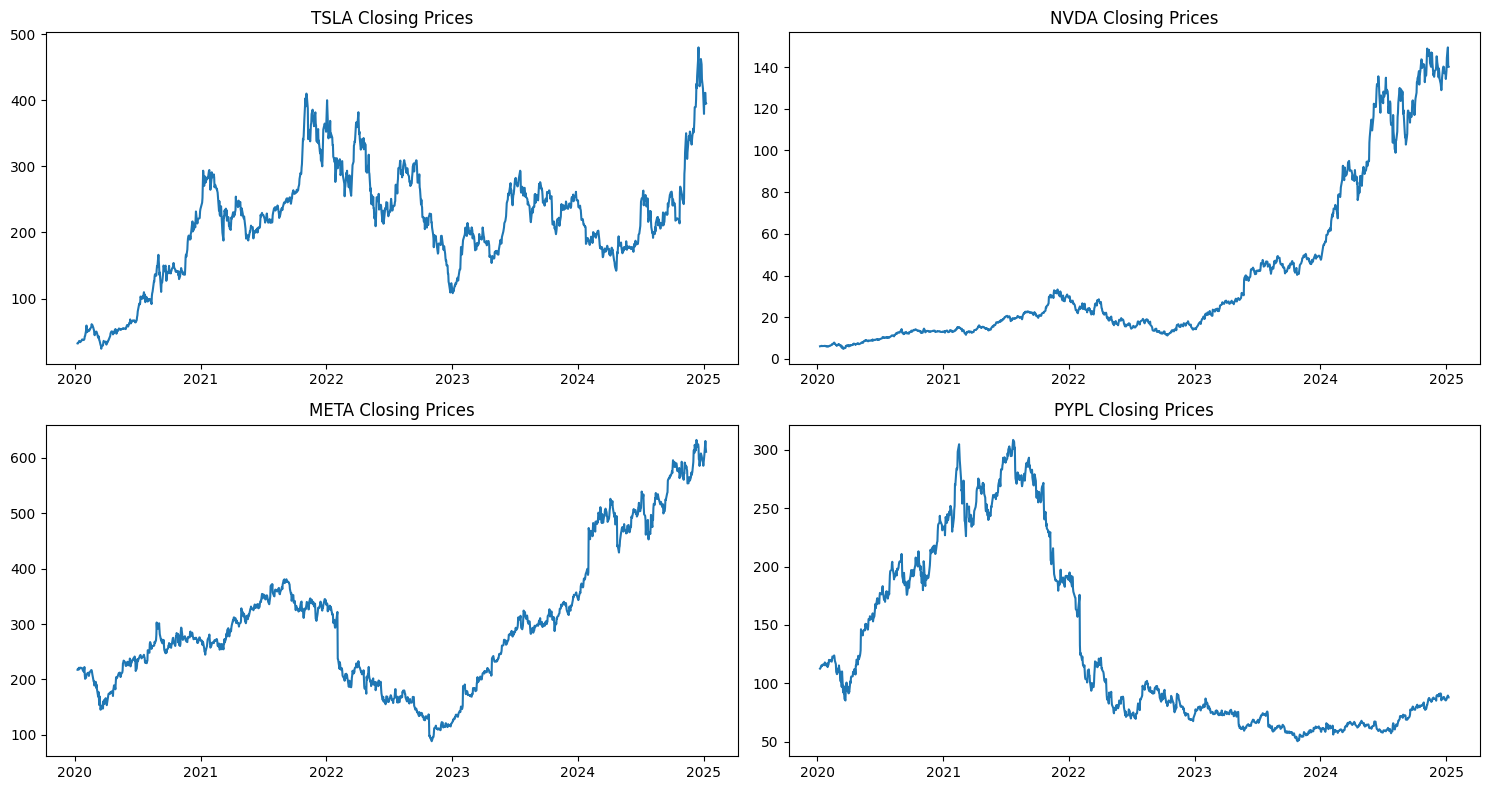

Total Progress: 100%|██████████| 24/24 [21:49<00:00, 54.54s/it]


Results for ('META',):
+----+--------+------------------+-------+-------+-------+---------+---------+----------+-------------+--------------------+
|    | Ticker |      Model       |  MAE  |  MSE  | RMSE  |  MAPE   |   R2    | Features | Window Size | Prediction Horizon |
+----+--------+------------------+-------+-------+-------+---------+---------+----------+-------------+--------------------+
| 44 |  META  | LinearRegression | 0.033 | 0.002 | 0.049 | 18.414  |  0.963  | Returns  |     112     |         84         |
| 41 |  META  | LinearRegression | 0.037 | 0.003 | 0.052 |  9.975  |  0.927  | Returns  |     112     |         28         |
| 38 |  META  | LinearRegression | 0.038 | 0.002 | 0.049 |  6.911  |  0.926  | Returns  |     112     |         1          |
| 53 |  META  | LinearRegression | 0.044 | 0.004 | 0.06  | 21.543  |  0.919  | Returns  |     224     |         84         |
| 47 |  META  | LinearRegression | 0.049 | 0.004 | 0.063 |  8.46   |  0.882  | Returns  |     224    

In [74]:
# Основная функция для запуска с одним признаком.
if __name__ == "__main__":
    tickers = ['TSLA', 'NVDA', 'META', 'PYPL']
    data = download_data(tickers, period="5y")

    # Построение графиков
    plot_data(data)

    # Определение всех возможных признаков
    all_features = ['Returns',]

    # Параметры для перебора
    window_sizes = [112, 224]  # Размеры окон
    prediction_horizons = [1, 28, 84]  # Горизонты предсказания

    # Сохранение всех результатов
    all_results = []

    # Вычисление общего количества запусков
    total_runs = len(tickers) * len(window_sizes) * len(prediction_horizons) * len(all_features)

    # Подготовка данных и обучение моделей
    with tqdm(total=total_runs, desc="Total Progress") as pbar:
        for ticker, df in data.items():
            df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
            
            for window_size in window_sizes:
                for prediction_horizon in prediction_horizons:
                    for feature in all_features:
                        # Создание признаков (только один признак)
                        df_with_features = create_features(df.copy(), features_to_generate=[feature])
                        
                        # Создание обучающих и тестовых данных
                        X_train, X_test, y_train, y_test, scaler = create_train_test_window(df_with_features, target_column='Close', window_size=window_size, prediction_horizon=prediction_horizon, )
                        
                        # Логирование начала обучения для тикера
                        log_table = [
                            ["Ticker", ticker],
                            ["Window Size", window_size],
                            ["Prediction Horizon", prediction_horizon],
                            ["Features", feature],
                            ["Action", "Starting training models"]
                        ]
                        logging.info(f"\n{tabulate(log_table, headers='firstrow', tablefmt='grid')}")
                        
                        # Обучение моделей
                        results = train_models(X_train[:, :, [0, -1]], X_test[:, :, [0, -1]], y_train, y_test, [feature], window_size, prediction_horizon, ticker=ticker)
                        all_results.extend(results)
                        
                        # Обновление прогресс-бара
                        pbar.update(1)

    # Логирование завершения всех задач
    logging.info("\nAll models trained successfully.")

    # Сохранение всех результатов в DataFrame
    results_df = pd.DataFrame(all_results)

    # Поиск наилучшей комбинации для каждой модели
    best_results = results_df.loc[results_df.groupby(['Ticker', 'Model', 'Window Size', 'Prediction Horizon'])['R2'].idxmax()]

    for Model, group in best_results.groupby([ 'Ticker',]):
        print(f"\nResults for {Model}:")
        print(tabulate(group.sort_values(by='R2', ascending=False), headers="keys", tablefmt="pretty"))

    # Сохранение результатов в файл
    timestamp = int(time.time())
    results_df.to_csv(f'single_feature_results_{timestamp}.csv', index=False)
    best_results.to_csv(f'best_single_feature_results_{timestamp}.csv', index=False)

Можно заметить, что META и NVDA оказались сложны для GradientBoosting и RandomForest, чего нельзя сказать о LinearRegression.

Удивительно предсказуема TSLA для всех моделей.

PYPL оказался предсказуем для наиболее коротких горизонтах.

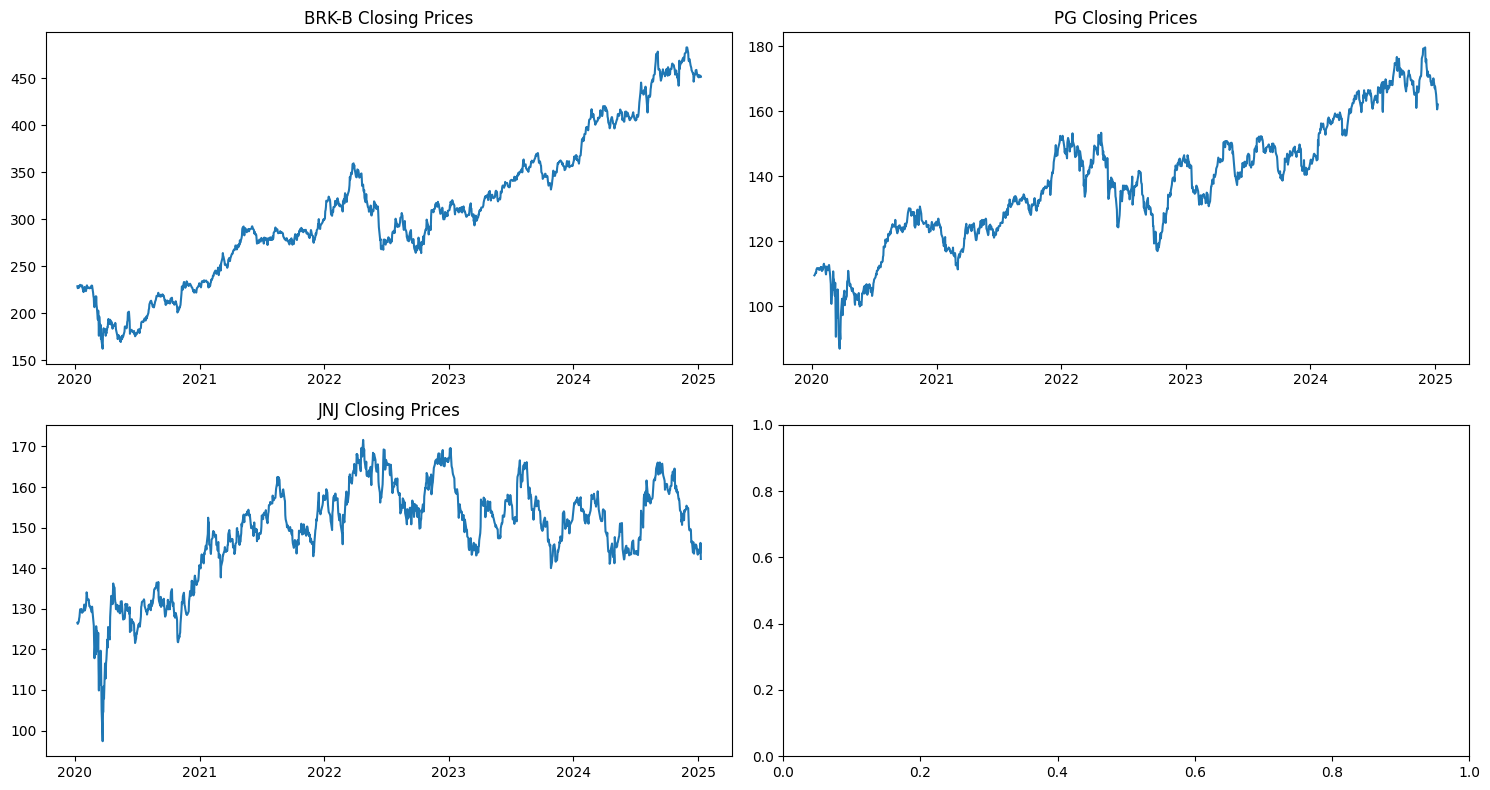

Total Progress: 100%|██████████| 18/18 [15:31<00:00, 51.77s/it]


Results for ('BRK-B',):
+----+--------+------------------+-------+-------+-------+--------+--------+----------+-------------+--------------------+
|    | Ticker |      Model       |  MAE  |  MSE  | RMSE  |  MAPE  |   R2   | Features | Window Size | Prediction Horizon |
+----+--------+------------------+-------+-------+-------+--------+--------+----------+-------------+--------------------+
| 8  | BRK-B  | LinearRegression | 0.023 | 0.001 | 0.03  | 5.068  | 0.976  | Returns  |     112     |         84         |
| 5  | BRK-B  | LinearRegression | 0.025 | 0.001 | 0.031 | 4.014  | 0.969  | Returns  |     112     |         28         |
| 2  | BRK-B  | LinearRegression | 0.025 | 0.001 | 0.032 | 3.572  | 0.959  | Returns  |     112     |         1          |
| 17 | BRK-B  | LinearRegression | 0.028 | 0.001 | 0.035 | 5.635  | 0.959  | Returns  |     224     |         84         |
| 14 | BRK-B  | LinearRegression | 0.029 | 0.001 | 0.037 | 4.384  | 0.944  | Returns  |     224     |         28  

In [75]:
# Основная функция для запуска с одним признаком.
if __name__ == "__main__":
    tickers = ['BRK-B', 'PG', 'JNJ',]
    data = download_data(tickers, period="5y")

    # Построение графиков
    plot_data(data)

    # Определение всех возможных признаков
    all_features = ['Returns',]

    # Параметры для перебора
    window_sizes = [112, 224]  # Размеры окон
    prediction_horizons = [1, 28, 84]  # Горизонты предсказания

    # Сохранение всех результатов
    all_results = []

    # Вычисление общего количества запусков
    total_runs = len(tickers) * len(window_sizes) * len(prediction_horizons) * len(all_features)

    # Подготовка данных и обучение моделей
    with tqdm(total=total_runs, desc="Total Progress") as pbar:
        for ticker, df in data.items():
            df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
            
            for window_size in window_sizes:
                for prediction_horizon in prediction_horizons:
                    for feature in all_features:
                        # Создание признаков (только один признак)
                        df_with_features = create_features(df.copy(), features_to_generate=[feature])
                        
                        # Создание обучающих и тестовых данных
                        X_train, X_test, y_train, y_test, scaler = create_train_test_window(df_with_features, target_column='Close', window_size=window_size, prediction_horizon=prediction_horizon, )
                        
                        # Логирование начала обучения для тикера
                        log_table = [
                            ["Ticker", ticker],
                            ["Window Size", window_size],
                            ["Prediction Horizon", prediction_horizon],
                            ["Features", feature],
                            ["Action", "Starting training models"]
                        ]
                        logging.info(f"\n{tabulate(log_table, headers='firstrow', tablefmt='grid')}")
                        
                        # Обучение моделей
                        results = train_models(X_train[:, :, [0, -1]], X_test[:, :, [0, -1]], y_train, y_test, [feature], window_size, prediction_horizon, ticker=ticker)
                        all_results.extend(results)
                        
                        # Обновление прогресс-бара
                        pbar.update(1)

    # Логирование завершения всех задач
    logging.info("\nAll models trained successfully.")

    # Сохранение всех результатов в DataFrame
    results_df = pd.DataFrame(all_results)

    # Поиск наилучшей комбинации для каждой модели
    best_results = results_df.loc[results_df.groupby(['Ticker', 'Model', 'Window Size', 'Prediction Horizon'])['R2'].idxmax()]

    for Model, group in best_results.groupby([ 'Ticker',]):
        print(f"\nResults for {Model}:")
        print(tabulate(group.sort_values(by='R2', ascending=False), headers="keys", tablefmt="pretty"))

    # Сохранение результатов в файл
    timestamp = int(time.time())
    results_df.to_csv(f'single_feature_results_{timestamp}.csv', index=False)
    best_results.to_csv(f'best_single_feature_results_{timestamp}.csv', index=False)

Наименее волатильные акции оказались как просты, так и сложны для прогнозирования. К сожалению, сделать точный вердикт, что волатильность влияет на качество предсказания нельзя. Однако, это еще одно подтверждение возможностей простейшей линейной регрессии.